In [1]:
import warnings
warnings.filterwarnings("ignore")

import numpy as np
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt
from catboost import CatBoostClassifier, Pool
import pandas_profiling
import eli5
import re
import pickle
from sklearn.model_selection import train_test_split

from pandarallel import pandarallel
import gbm_model

'''
, cross_val_score, StratifiedKFold
from sklearn.metrics import confusion_matrix, roc_auc_score, f1_score, precision_recall_curve, plot_precision_recall_curve, average_precision_score
from sklearn.pipeline import make_pipeline
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.linear_model import LogisticRegression
from sklearn.preprocessing import StandardScaler
from sklearn.decomposition import TruncatedSVD
from sklearn.externals import joblib

from urllib.parse import urlparse
from nltk.tokenize import RegexpTokenizer 
from nltk.stem.snowball import SnowballStemmer

from pandarallel import pandarallel
'''


'\n, cross_val_score, StratifiedKFold\nfrom sklearn.metrics import confusion_matrix, roc_auc_score, f1_score, precision_recall_curve, plot_precision_recall_curve, average_precision_score\nfrom sklearn.pipeline import make_pipeline\nfrom sklearn.feature_extraction.text import TfidfVectorizer\nfrom sklearn.linear_model import LogisticRegression\nfrom sklearn.preprocessing import StandardScaler\nfrom sklearn.decomposition import TruncatedSVD\nfrom sklearn.externals import joblib\n\nfrom urllib.parse import urlparse\nfrom nltk.tokenize import RegexpTokenizer \nfrom nltk.stem.snowball import SnowballStemmer\n\nfrom pandarallel import pandarallel\n'

In [2]:
pandarallel.initialize()
pd.set_option('display.max_colwidth', None)
sns.set_style('darkgrid')
RANDOM_STATE = 42

INFO: Pandarallel will run on 16 workers.
INFO: Pandarallel will use Memory file system to transfer data between the main process and workers.


In [6]:
df_small = pd.read_csv('data/urls.csv')
df_big = pd.read_csv('data/data.csv')
df = pd.concat([df_small, df_big], axis=0)
df.reset_index(drop=True, inplace=True)
df['label'] = df['label'].parallel_apply(lambda label: 1 if (label == 'Unsafe') or (label == 'bad') else 0)
df, level0_text  = train_test_split(df,
                                    random_state = RANDOM_STATE,
                                    test_size = 0.15,
                                    stratify=df['label'])
df.reset_index(drop=True, inplace=True)
level0_text.reset_index(drop=True, inplace=True)
df.to_csv('data/big.csv', index=False)
level0_text.to_csv('data/level0.csv', index=False)

In [4]:
train_data, train_labels, val_data, val_labels, test_data, test_labels = gbm_model.preprocess(df, is_fitted = False)

In [5]:
gbm = CatBoostClassifier(task_type="GPU", logging_level='Silent', 
                         loss_function='Logloss', od_type='Iter')
cv_results = gbm_model.get_cross_val(gbm, train_data, train_labels)
print(cv_results)

[0.98657946 0.98585187 0.98574352 0.98548946 0.98520669]


roc_auc:  0.9890290064251793
f1:  0.9138305575669805


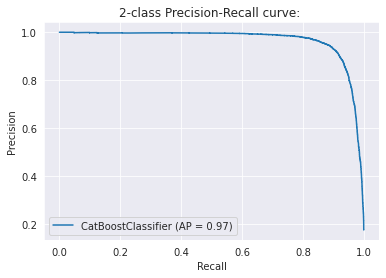

In [7]:
gbm = gbm_model.train_gbm(train_data, train_labels, val_data, val_labels, test_data, test_labels)

In [8]:
eli5.explain_weights_catboost(gbm, vec=None, top=20, importance_type='PredictionValuesChange', feature_names=None, pool=None)

Weight,Feature
0.1125,path_len
0.0565,7
0.0501,4
0.0426,0
0.0391,39
0.0327,1
0.0275,path_nums
0.0253,14
0.0249,33
0.0242,27
